Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'
data_root = '../../input/data_compression/' # Change me to store data elsewhere

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if not os.path.exists(dest_filename):
        filename, _ = urlretrieve(url + filename, dest_filename)
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % dest_filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename


filename = maybe_download('text8.zip', 31344016)

Found and verified ../../input/data_compression/text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # count = Counter({'abc': 3, 'cde': 2, 'bcd': 1, 'def': 1})
    
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # dictionary = ('abc': 1, 'cde': 2, 'bcd': 3, 'def': 4)    
    
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [8]:
data_index = 0


def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window

    # print("batch_size =", batch_size)
    # print("num_skips =", num_skips)
    # print("skip_window =", skip_window)

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)  # batch.shape = [8]
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # labels.shape = [8, 1]
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]

    # print("span =", span)

    # use deque to append the new word at the tail , push the old word out from top
    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        # pick the word's rank/index into buffer [3]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # print("buffer =", buffer)
    # print("data_index =", data_index)

    # Buffer : deque([5234, 3081, 12])

    for i in range(batch_size // num_skips): # 4
        target = skip_window  # target label at the center of the buffer , 1 of [0..2]
        targets_to_avoid = [skip_window]   # [1]
        for j in range(num_skips): # (0...1)

            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
                # random number from (0, 1, 2) until find a number not in targets_to_avoid
                # to get the new neighbour words

            targets_to_avoid.append(target)
            # print("i:", i, "j:", j, "targets_to_avoid:",targets_to_avoid, "buffer =", buffer)

            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target] # neighbour of the words
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # print("batch =", batch)
    # print("labels =", labels)
    # print("buffer =", buffer)
    # print("data_index =", data_index)

    return batch, labels


In [9]:

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'anarchism', 'term', 'originated', 'of', 'as', 'term', 'originated']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_norm_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

    # Calculate cosine distance from valid words to all the other words.
    # cosine distance represent the similarity between 2 words.
    similarity = tf.matmul(valid_norm_embeddings, tf.transpose(normalized_embeddings))


In [10]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0

        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):

                valid_word = reverse_dictionary[valid_examples[i]]

                top_k = 8  # number of nearest neighbors
                # ignore 0 , 0 refer to itself
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
                
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.417866
Nearest to up: derisively, traction, alberoni, spans, matched, anatolian, troppo, potsdam,
Nearest to of: beauties, pizarro, unidentified, warms, crackers, derleth, sequencer, administer,
Nearest to s: moths, toppling, nokia, employs, subhas, pork, faure, breached,
Nearest to history: claimant, amethyst, heeled, those, yuga, hitchens, dddddd, dominated,
Nearest to and: fortnight, tractor, ata, bnf, audrey, skip, flagship, mpla,
Nearest to from: neighbours, concentrate, sensory, riga, pitching, malware, surprised, legalism,
Nearest to by: rulings, computation, obstetrics, veneer, rites, magazines, disraeli, linton,
Nearest to however: checklist, coro, repairs, nippon, uninterrupted, reversible, politecnico, dd,
Nearest to a: prasad, tidy, tines, realign, trainees, netscape, vilnius, currency,
Nearest to there: descriptive, lipoprotein, navigated, deadliest, crusader, alberti, simons, erroneously,
Nearest to between: zombie, dismantled, coffey

Nearest to only: not, however, otters, soe, affect, gai, likely, destroyed,
Nearest to th: nd, six, eight, rd, seven, deaths, st, three,
Nearest to one: eight, nine, seven, four, two, five, six, three,
Nearest to as: slovenes, denarius, known, microcebus, well, such, defined, honeybees,
Nearest to on: in, illiteracy, upon, giantess, from, libri, lugo, kbit,
Average loss at step 52000: 3.666968
Average loss at step 54000: 3.757074
Average loss at step 56000: 3.739483
Average loss at step 58000: 3.660032
Average loss at step 60000: 3.724457
Nearest to up: them, tricolor, forward, eurasian, troppo, march, according, between,
Nearest to of: in, contains, within, understandably, for, larps, patrol, during,
Nearest to s: his, fiorentina, emil, waterloo, nokia, admissions, exothermic, deconstructionist,
Nearest to history: list, psalms, xn, majority, upheavals, usa, albania, greece,
Nearest to and: or, through, but, while, with, from, in, to,
Nearest to from: into, through, and, at, before, i

In [11]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

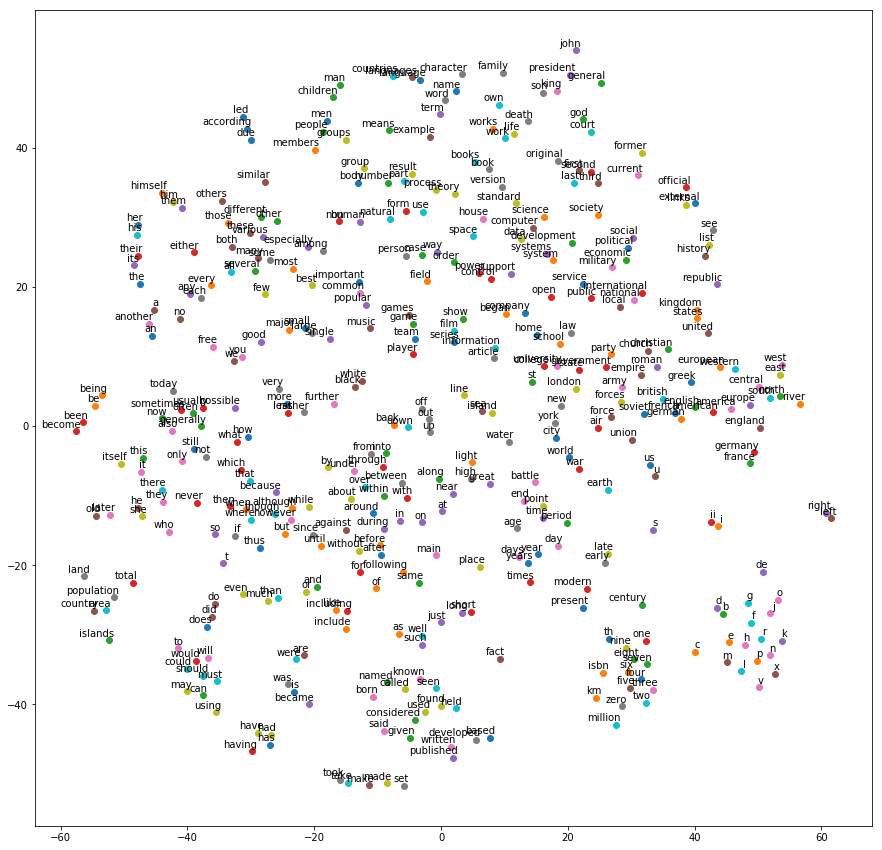

In [12]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()


words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---